In [1]:
import numpy as np, pandas as pd, lightgbm as lgb, warnings
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from tqdm import tqdm_notebook as tqdm

/Users/akurochkin/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
warnings.filterwarnings('ignore')
data_folder = 'data'

In [4]:
random_state = 42
np.random.seed(random_state)

In [5]:
train_df, test_df = pd.read_csv(data_folder+'/train.csv'), pd.read_csv(data_folder+'/test.csv')

In [6]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [7]:
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


#### LightGBM approache (CV score: 0.90053)

https://www.kaggle.com/mhviraf/santander-compact-solution-14-lines-will-do

In [7]:
N_SPLITS = 15
SHUFFLE = False
RANDOM_STATE = 2319

In [9]:
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]

param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.331,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.0405,
    'learning_rate': 0.0083,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary',
    'verbosity': 1
}

folds =  StratifiedKFold(n_splits=N_SPLITS,\
                         shuffle=SHUFFLE,\
                         random_state=RANDOM_STATE)

oof = np.zeros(len(train_df)), 
predictions = np.zeros(len(test_df))


In [11]:
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, train_df['target'].values)):
    print("Fold {}".format(fold_))
    
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features],\
                           label=train_df['target'].iloc[trn_idx])
    
    val_data = lgb.Dataset(train_df.iloc[val_idx][features],\
                           label=train_df['target'].iloc[val_idx])
    
    clf = lgb.train(param,\
                    trn_data,\
                    1000000,\
                    valid_sets = [trn_data, val_data],\
                    verbose_eval=5000,\
                    early_stopping_rounds = 4000)
    
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features],\
                               num_iteration=clf.best_iteration)
    
    predictions += clf.predict(test_df[features],\
                               num_iteration=clf.best_iteration) / folds.n_splits

Fold 0
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.924417	valid_1's auc: 0.89887
[10000]	training's auc: 0.939862	valid_1's auc: 0.901961
[15000]	training's auc: 0.952448	valid_1's auc: 0.902155
Early stopping, best iteration is:
[11245]	training's auc: 0.943199	valid_1's auc: 0.902323
Fold 1
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.925071	valid_1's auc: 0.89182
[10000]	training's auc: 0.940421	valid_1's auc: 0.893967
[15000]	training's auc: 0.952968	valid_1's auc: 0.893958
Early stopping, best iteration is:
[13122]	training's auc: 0.948429	valid_1's auc: 0.894314
Fold 2
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.924373	valid_1's auc: 0.901966
[10000]	training's auc: 0.939811	valid_1's auc: 0.903669
Early stopping, best iteration is:
[10639]	training's auc: 0.941514	valid_1's auc: 0.903793
Fold 3
Training until validation scores don't improve for 40

In [13]:
print("CV score: {:<8.5f}".format(roc_auc_score(train_df['target'], oof)))
pd.DataFrame({"ID_code": test_df.ID_code.values, 'target':predictions}).to_csv("submission.csv", index=False)

CV score: 0.90053 


#### LGB 2 leaves + augment (CV score: 0.90168)
https://www.kaggle.com/jiweiliu/lgb-2-leaves-augment

In [8]:
def augment(x, y, t=2):
    xs,xn = [],[]
    
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

In [9]:
lgb_params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : -1,
    "num_leaves" : 13,
    "learning_rate" : 0.01,
    "bagging_freq": 5,
    "bagging_fraction" : 0.4,
    "feature_fraction" : 0.05,
    "min_data_in_leaf": 80,
    "min_sum_heassian_in_leaf": 10,
    "tree_learner": "serial",
    "boost_from_average": "false",
    #"lambda_l1" : 5,
    #"lambda_l2" : 5,
    "bagging_seed" : random_state,
    "verbosity" : 1,
    "seed": random_state
}

In [10]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
oof = train_df[['ID_code', 'target']]
oof['predict'] = 0
predictions = test_df[['ID_code']]
val_aucs = []
feature_importance_df = pd.DataFrame()

In [12]:
features = [col for col in train_df.columns if col not in ['target', 'ID_code']]
X_test = test_df[features].values

In [13]:
for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
    X_train, y_train = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx]['target']
    X_valid, y_valid = train_df.iloc[val_idx][features], train_df.iloc[val_idx]['target']
    
    N = 5
    p_valid,yp = 0,0
    for i in range(N):
        X_t, y_t = augment(X_train.values, y_train.values)
        X_t = pd.DataFrame(X_t)
        X_t = X_t.add_prefix('var_')
    
        trn_data = lgb.Dataset(X_t, label=y_t)
        val_data = lgb.Dataset(X_valid, label=y_valid)
        evals_result = {}
        lgb_clf = lgb.train(lgb_params,
                        trn_data,
                        100000,
                        valid_sets = [trn_data, val_data],
                        early_stopping_rounds=3000,
                        verbose_eval = 1000,
                        evals_result=evals_result
                       )
        p_valid += lgb_clf.predict(X_valid)
        yp += lgb_clf.predict(X_test)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = lgb_clf.feature_importance()
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    oof['predict'][val_idx] = p_valid/N
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)
    
    predictions['fold{}'.format(fold+1)] = yp/N

Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.893089	valid_1's auc: 0.881635
[2000]	training's auc: 0.901658	valid_1's auc: 0.888588
[3000]	training's auc: 0.907975	valid_1's auc: 0.893037
[4000]	training's auc: 0.912801	valid_1's auc: 0.895956
[5000]	training's auc: 0.916515	valid_1's auc: 0.897858
[6000]	training's auc: 0.919519	valid_1's auc: 0.898945
[7000]	training's auc: 0.922135	valid_1's auc: 0.899443
[8000]	training's auc: 0.924556	valid_1's auc: 0.899735
[9000]	training's auc: 0.926832	valid_1's auc: 0.899859
[10000]	training's auc: 0.929012	valid_1's auc: 0.899978
[11000]	training's auc: 0.931155	valid_1's auc: 0.900039
[12000]	training's auc: 0.933231	valid_1's auc: 0.899946
[13000]	training's auc: 0.935206	valid_1's auc: 0.899985
Early stopping, best iteration is:
[10529]	training's auc: 0.930151	valid_1's auc: 0.900098
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.892958	valid_1's auc: 0

Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.892428	valid_1's auc: 0.883767
[2000]	training's auc: 0.901221	valid_1's auc: 0.89028
[3000]	training's auc: 0.90759	valid_1's auc: 0.894442
[4000]	training's auc: 0.912388	valid_1's auc: 0.897353
[5000]	training's auc: 0.916163	valid_1's auc: 0.898967
[6000]	training's auc: 0.919187	valid_1's auc: 0.899973
[7000]	training's auc: 0.921809	valid_1's auc: 0.90053
[8000]	training's auc: 0.92425	valid_1's auc: 0.900696
[9000]	training's auc: 0.926554	valid_1's auc: 0.900763
[10000]	training's auc: 0.928744	valid_1's auc: 0.900813
[11000]	training's auc: 0.930873	valid_1's auc: 0.900751
[12000]	training's auc: 0.932938	valid_1's auc: 0.900771
Early stopping, best iteration is:
[9868]	training's auc: 0.928466	valid_1's auc: 0.900827
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.891674	valid_1's auc: 0.886618
[2000]	training's auc: 0.900399	valid_1's auc: 0.89443

[1000]	training's auc: 0.89222	valid_1's auc: 0.879632
[2000]	training's auc: 0.900952	valid_1's auc: 0.886588
[3000]	training's auc: 0.907183	valid_1's auc: 0.89129
[4000]	training's auc: 0.911966	valid_1's auc: 0.894474
[5000]	training's auc: 0.915704	valid_1's auc: 0.896704
[6000]	training's auc: 0.918708	valid_1's auc: 0.897982
[7000]	training's auc: 0.921335	valid_1's auc: 0.89879
[8000]	training's auc: 0.923777	valid_1's auc: 0.899333
[9000]	training's auc: 0.926071	valid_1's auc: 0.899628
[10000]	training's auc: 0.928285	valid_1's auc: 0.899738
[11000]	training's auc: 0.930405	valid_1's auc: 0.899817
[12000]	training's auc: 0.932478	valid_1's auc: 0.899867
[13000]	training's auc: 0.934499	valid_1's auc: 0.899846
[14000]	training's auc: 0.936522	valid_1's auc: 0.899835
Early stopping, best iteration is:
[11884]	training's auc: 0.932242	valid_1's auc: 0.899895
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.892525	valid_1's auc: 0.879663
[2

In [14]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['target'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.901683442, std: 0.003053738. All auc: 0.901652342.


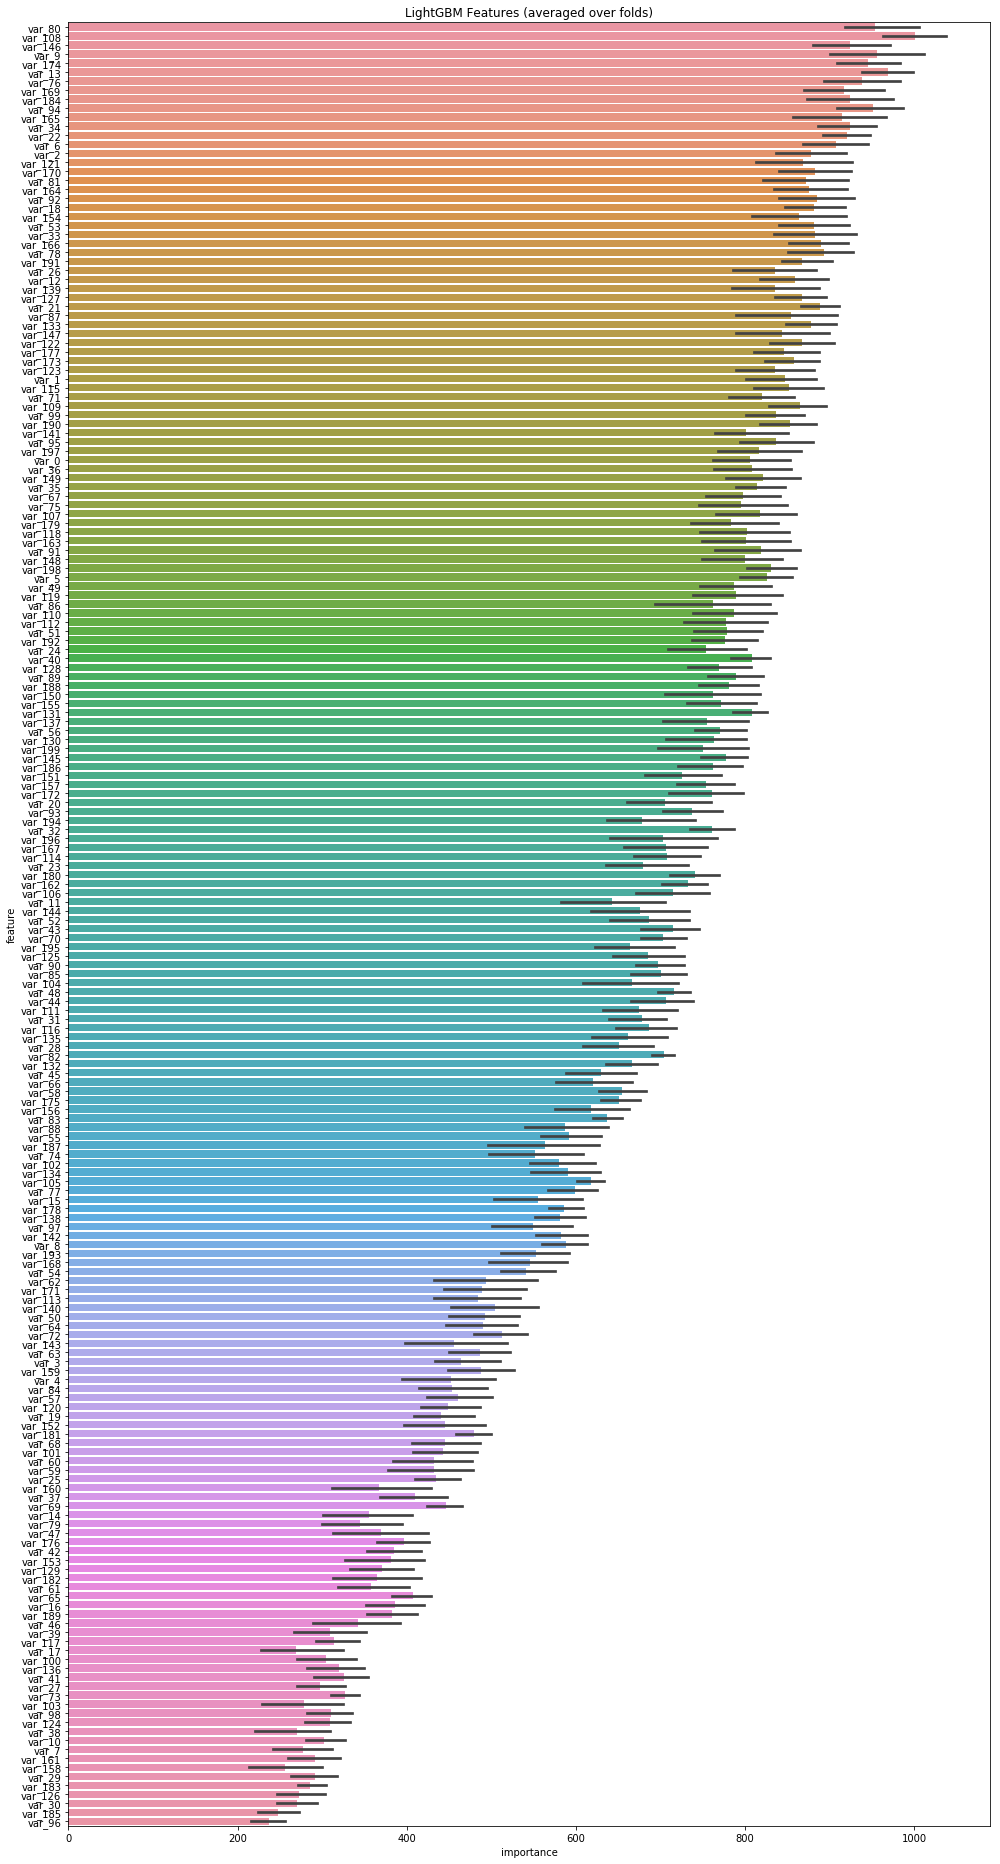

In [17]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()

#plt.savefig('lgbm_importances.png')

In [19]:
# submission
predictions['target'] = np.mean(predictions[[col for col in predictions.columns if col not in ['ID_code', 'target']]].values, axis=1)
predictions.to_csv('lgb_all_predictions.csv', index=None)
sub_df = pd.DataFrame({"ID_code":test_df["ID_code"].values})
sub_df["target"] = predictions['target']
sub_df.to_csv("lgb_submission.csv", index=False)
oof.to_csv('lgb_oof.csv', index=False)